<a href="https://colab.research.google.com/github/naenumtou/learnTensorFlow/blob/main/COVIDXRay/LIMEImageExplainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [ ]:
# Install library
!pip install lime

     |████████████████████████████████| 275 kB 5.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=80b7e3fbe4f03c42bba9603deb4a36b775117c4769bcdfe18370ac4b2b8ded7a
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
# Change working directory
%cd /content/drive/My Drive/Colab Notebooks/COVIDXRay

/content/drive/My Drive/Colab Notebooks/COVIDXRay


In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from skimage.segmentation import quickshift, mark_boundaries
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import load_model
from lime.lime_image import LimeImageExplainer

# Config
%config InlineBackend.figure_format = 'retina' #Retina display

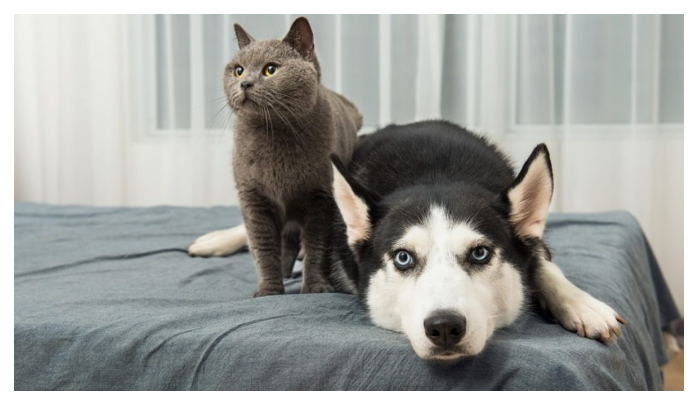

In [ ]:
# Example image for LIME Explainer
sampleImage = cv2.imread('cat-husky.jpg')
plt.figure(figsize = (6, 6))
plt.imshow(sampleImage[:, :, ::-1])
plt.axis('off')
plt.show()

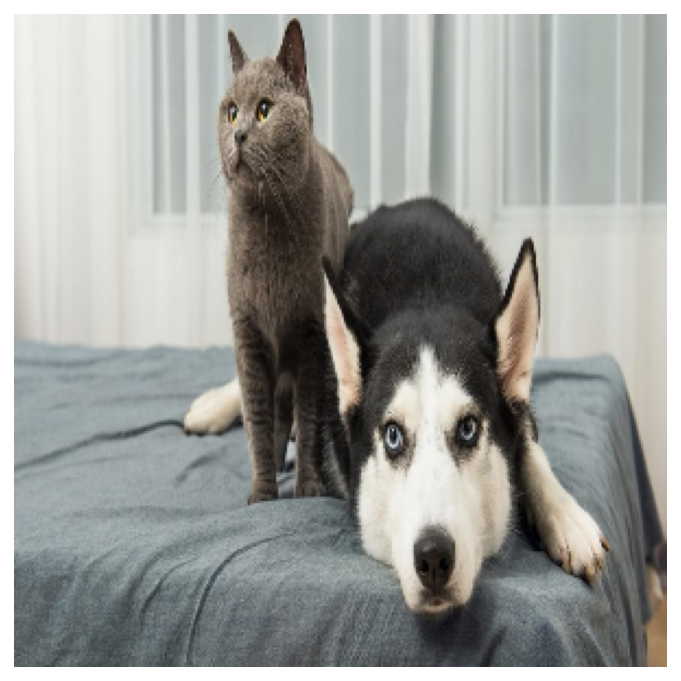

In [ ]:
# Use TensorFlow model to predict classes
# Image processing for Xception pre-trained model
sampleImage = cv2.resize(sampleImage, (299, 299)) #Default size
sampleImage = sampleImage / 255.0
plt.figure(figsize = (6, 6))
plt.imshow(sampleImage[:, :, ::-1])
plt.axis('off')
plt.show()

In [ ]:
# Xception model
XceptionModel = Xception() #Load model
pred = XceptionModel.predict(sampleImage.reshape(-1, 299, 299, 3))
decode_predictions(pred, top = 1)[0] #Most confidence class

49152/35363 [=========================================] - 0s 0us/step


[('n02109961', 'Eskimo_dog', 0.2517574)]

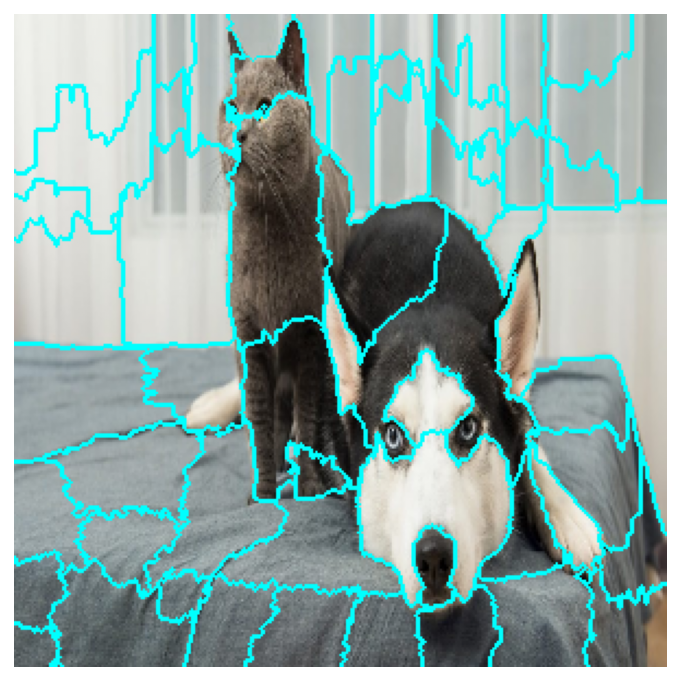

In [ ]:
# Image segmentation
superpixels = quickshift(
    sampleImage,
    kernel_size = 4,
    max_dist = 200,
    ratio = 0.2
)

# Show segmentation
plt.figure(figsize = (6, 6))
plt.imshow(mark_boundaries(sampleImage, superpixels)[:, :, ::-1])
plt.axis('off')
plt.show()

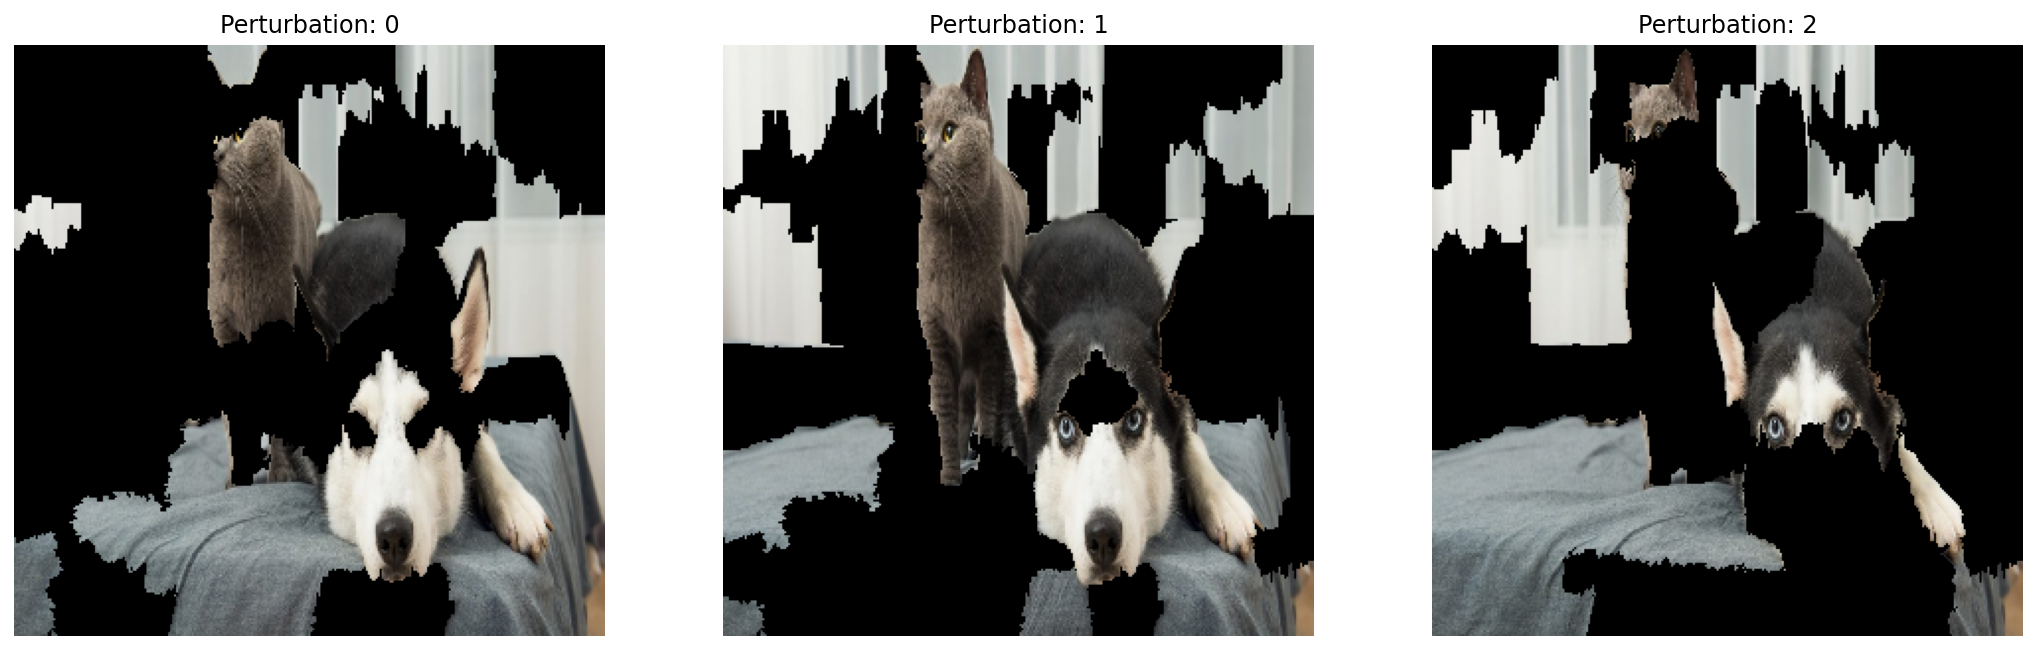

In [ ]:
# Generate perturbations
perturbations = np.random.binomial(
    1,
    0.5,
    size = (150, np.unique(superpixels).shape[0])
)

# Apply perturbations to image
def perturbationImage(image, pert, i = None):
  if i is None:
    activePixel = np.where(pert == 1)[0]
  else:
    activePixel = np.where(pert[i] == 1)[0] #Get random perturbations
  mask = np.zeros(superpixels.shape) #Create 0 image
  # Change mask to active
  for active in activePixel:
    mask[superpixels == active] = 1
  mask = mask.reshape(299, 299, 1) #Reshape to 3-D
  perturbedImage = image.copy()
  perturbedImage = perturbedImage * mask
  return perturbedImage

# Show perturbations image
plt.figure(figsize = (18, 6))
for i in range(0, 3):
  plt.subplot(1, 3, i + 1)
  perturbedImage = perturbationImage(sampleImage, perturbations, i)
  plt.imshow(perturbedImage[:, :, ::-1])
  plt.title(f'Perturbation: {i}')
  plt.axis('off')
plt.show()

In [ ]:
# Prediction class for perturbations image
preds = []

for i in perturbations:
  perturbedImage = perturbationImage(sampleImage, perturbations, i)
  pred = XceptionModel.predict(perturbedImage.reshape(-1, 299, 299, 3))
  preds.append(pred)

In [ ]:
# Compute distances from original image (from 1)
ones = np.ones(np.unique(superpixels).shape[0]).reshape(1, -1) #Enable all superpixels (2-D Array)
distances = pairwise_distances(
    perturbations,
    ones,
    metric = 'cosine'
).ravel() #1-D Array

# Compute weight to (0, 1) by kernel function
kernelWidth = 0.25
weights = np.sqrt(np.exp(-(distances ** 2) / kernelWidth ** 2)) #Kernel function

In [ ]:
# Estimate linear model
linearModel = LinearRegression()
classToExplain = pred[0].argsort()[-1] #From Xception model (Top class)
linearModel.fit(
    perturbations,
    np.array(preds)[:, :, classToExplain], #1 Interested class from prediction array (150, 1, 1000)
    sample_weight = weights
)

LinearRegression()

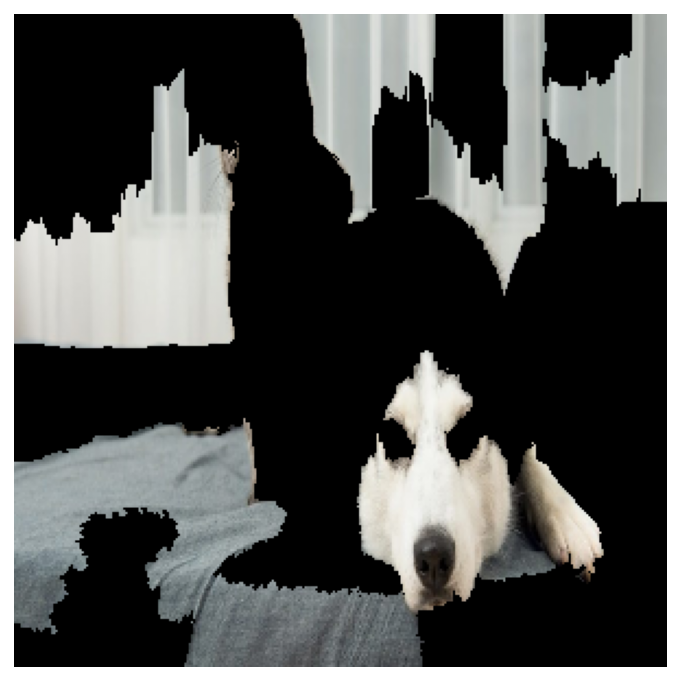

In [ ]:
# Use coefficients to extract top features
ntopFeatures = 25
topFeatures = linearModel.coef_[0].argsort()[-ntopFeatures:] #Top 25 Features

# Show superpixels corresponding to the top features
mask = np.zeros(np.unique(superpixels).shape[0]) #Zero array
mask[topFeatures] = True #Activate only top 25 Features
resultImage = perturbationImage(sampleImage, mask)
plt.figure(figsize = (6, 6))
plt.imshow(resultImage[:, :, ::-1])
plt.axis('off')
plt.show()

In [ ]:
# Generate images data
size = 128 #Image size
images = [
          'covid-19_01.jpg',
          'covid-19_02.jpg',
          'covid-19_03.jpg',
          'normal_01.jpg',
          'normal_02.jpg',
          'normal_03.jpg',
          'normal_04.jpg',
          'normal_05.jpg'
]

imagesData = []
for imageFile in images:
  image = cv2.imread(imageFile) #BGR
  image = cv2.resize(image, (size, size))
  image = image.reshape(size, size, 3) #Don't need to be 4-D
  image = image / 255.0
  imagesData.append(image)

In [ ]:
# Load model
modelCNN = load_model('COVID19CNN.model') #CNN
modelTrans = load_model('COVID19Xception.model') #Xception

In [ ]:
# LIME Image explainer
explainer = LimeImageExplainer()

# Define explainer function
def imageExplain(i, predictor, topLables, nSample):
  if predictor == 'CNN':
    model = modelCNN
  else:
    model = modelTrans
  explaination = explainer.explain_instance(
      imagesData[i].astype('double'),
      model.predict,
      top_labels = topLables,
      num_samples = nSample
  )
  return explaination

def imageShow(explaingImage, positive = True, hide = False):
  if positive is not True:
    positive = False
  if hide is not False:
    hide = True
  bound, mask = explaingImage.get_image_and_mask(
      explaingImage.top_labels[0],
      positive_only = positive,
      num_features = 10,
      hide_rest = hide
  )
  plt.figure(figsize = (6, 6))
  plt.imshow(mark_boundaries(bound, mask))
  plt.axis('off')
  return plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

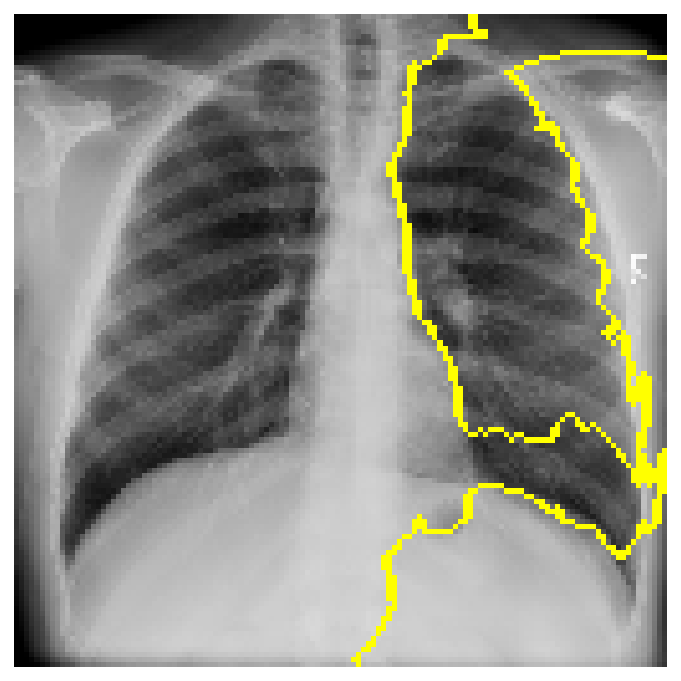

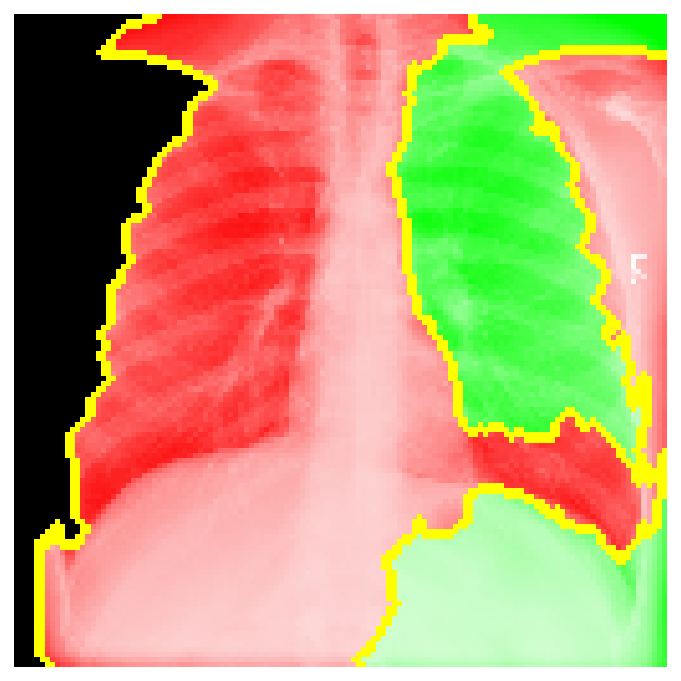

In [ ]:
# First image (COVID-19)
imageExp = imageExplain(0, 'CNN', 3, 500)

# Show
imageShow(imageExp)
imageShow(imageExp, False, True) #Show highlighting

  0%|          | 0/500 [00:00<?, ?it/s]

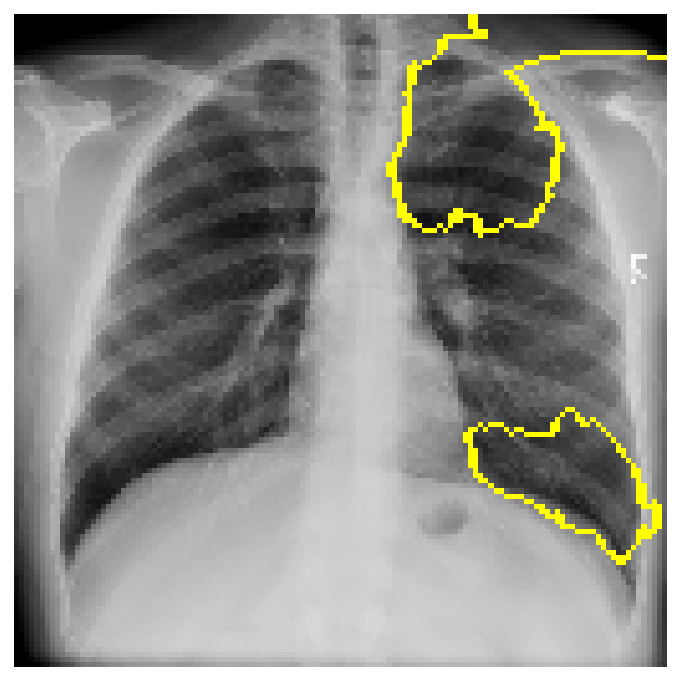

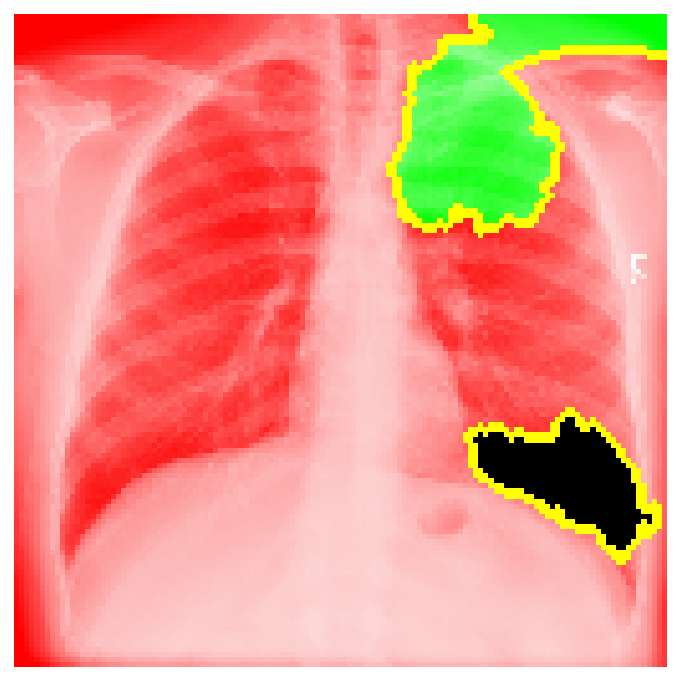

In [ ]:
# First image (COVID-19)
imageExp = imageExplain(0, 'Xception', 3, 500)

# Show
imageShow(imageExp)
imageShow(imageExp, False, True)

  0%|          | 0/500 [00:00<?, ?it/s]

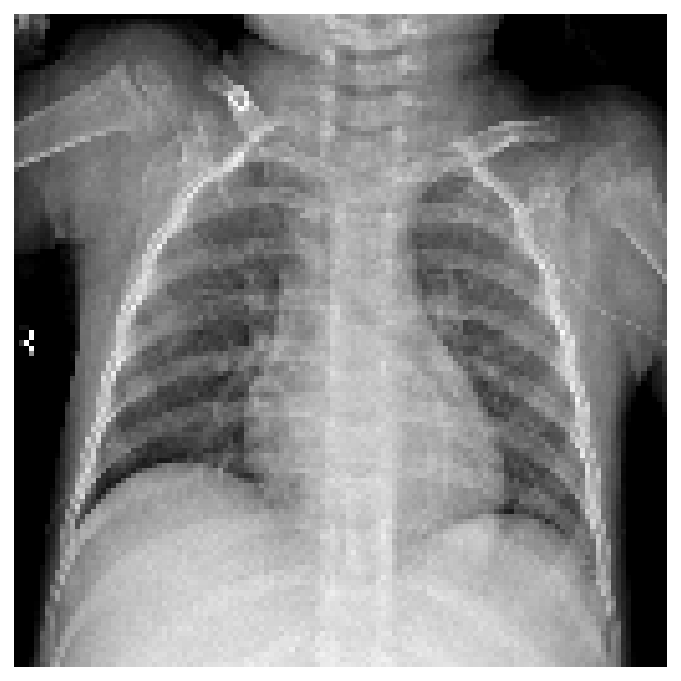

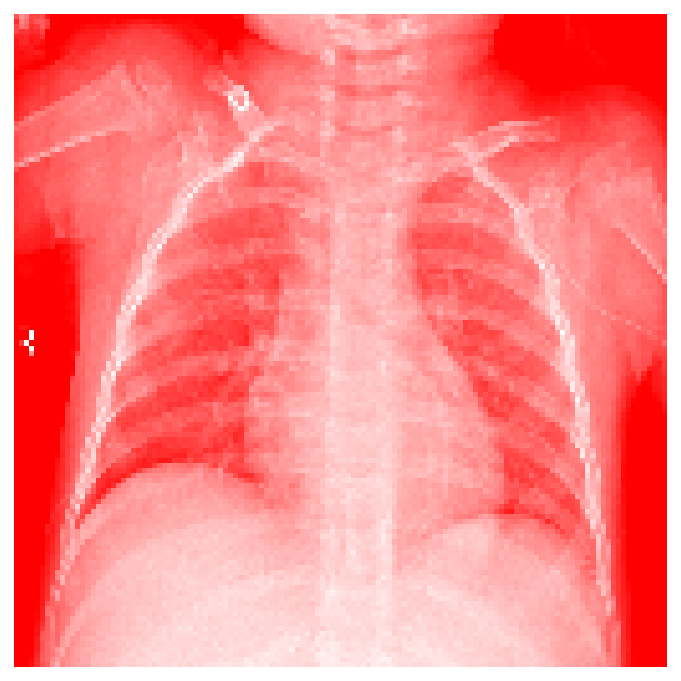

In [ ]:
# Fourth image (Normal)
imageExp = imageExplain(3, 'CNN', 3, 500)

# Show
imageShow(imageExp)
imageShow(imageExp, False, True)

  0%|          | 0/500 [00:00<?, ?it/s]

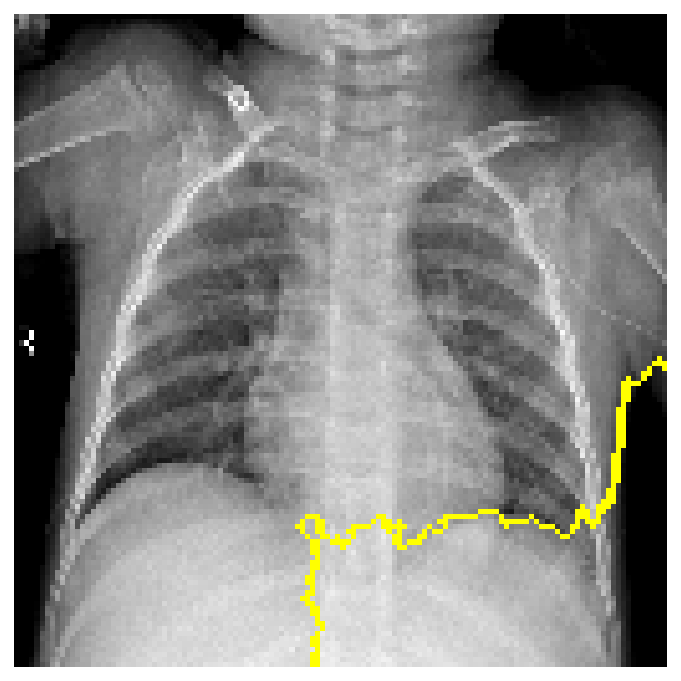

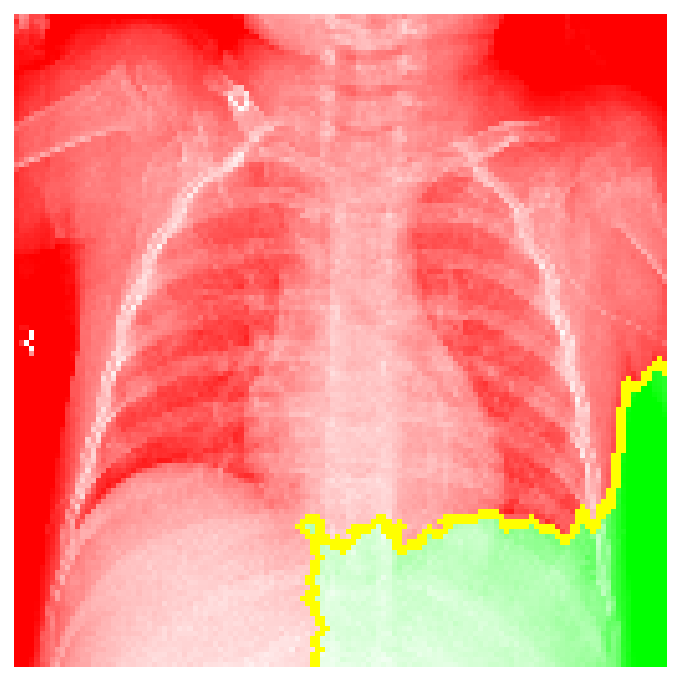

In [ ]:
# Fourth image (Normal)
imageExp = imageExplain(3, 'Xception', 3, 500)

# Show
imageShow(imageExp)
imageShow(imageExp, False, True)

  0%|          | 0/500 [00:00<?, ?it/s]

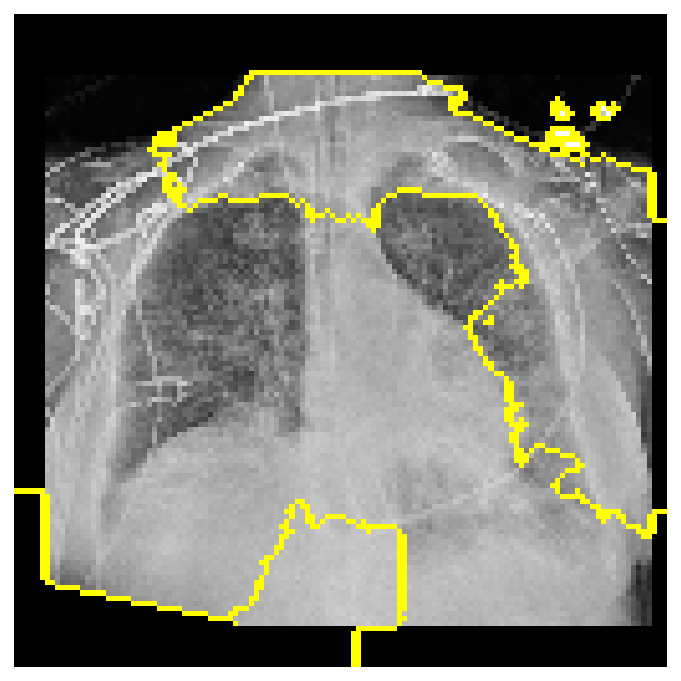

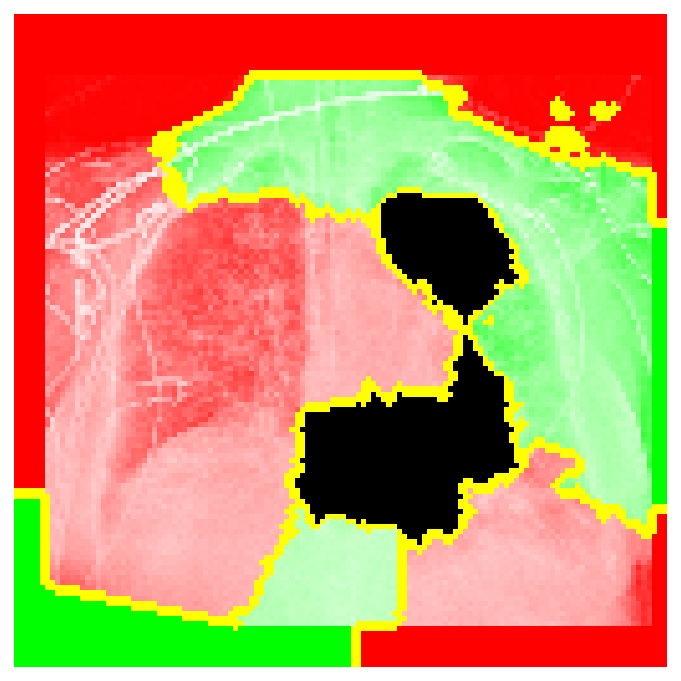

In [ ]:
# Third image --> COVID-19
# CNN --> COVID-19
imageExp = imageExplain(2, 'CNN', 3, 500)

# Show
imageShow(imageExp)
imageShow(imageExp, False, True)

  0%|          | 0/500 [00:00<?, ?it/s]

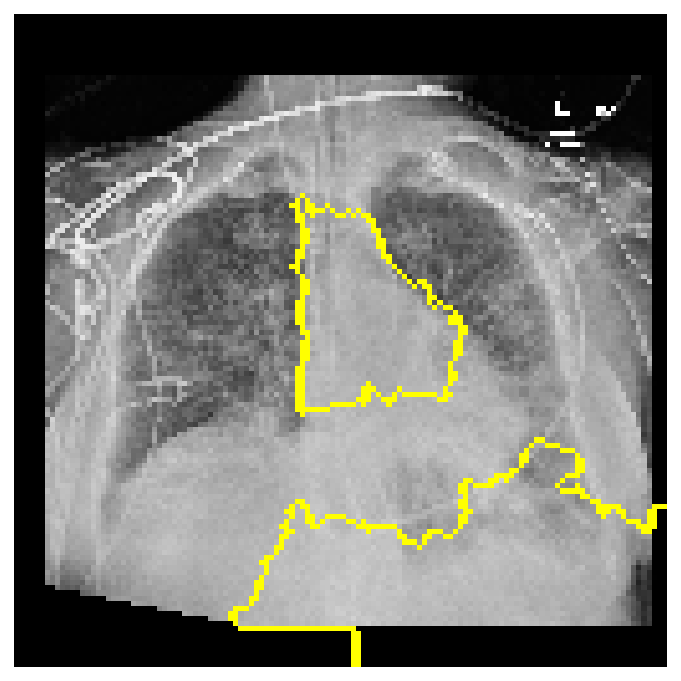

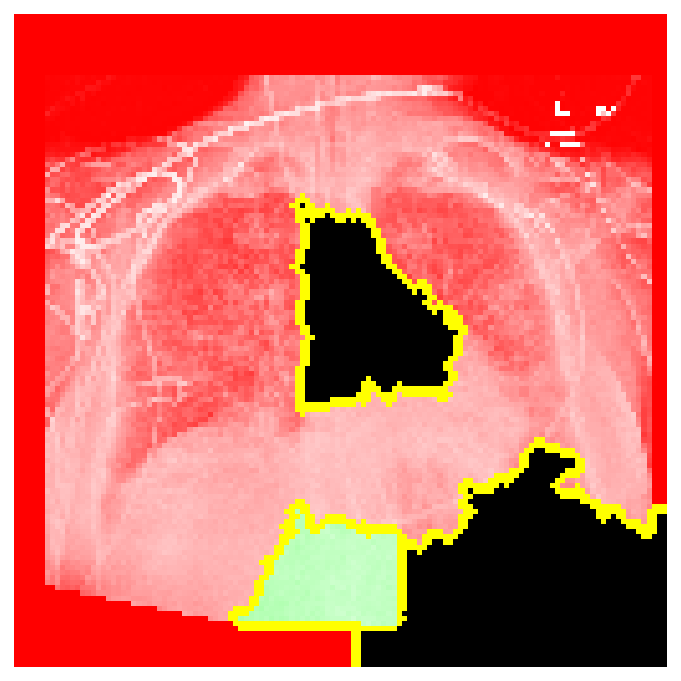

In [ ]:
# Xception --> Normal
imageExp = imageExplain(2, 'Xception', 3, 500)

# Show
imageShow(imageExp)
imageShow(imageExp, False, True)